# Preparation of the electron starting positions into COMSOL

## COMSOL feature: Release from Datafile

### ParticleTracingModuleUsersGuide.pdf, page 110 ff


Use a Release from Data File node to release particles by specifying the initial position, velocity, and values of auxiliary dependent variables using data from a text file.
Go to Release for information about the following sections: Release Times, Release Current Magnitude, Mass Flow Rate, Released Particle Properties, Initial Particle Temperature, Initial Multiplication Factor, and Advanced Settings.

Formatting Guidelines for Files Containing Particle Data
The imported data file should be a text file (*.txt) arranged in a spreadsheet format; that is, each row corresponds to a distinct particle and should have the same number of columns as all other rows. Columns can be separated by spaces, tabs, or a combination of the two. Begin a line with the percent (“%”) character to include comments or empty lines in the data file.
For example, a data file containing the following text would insert particles at the positions (0.1, 0.2, 0.6) and (0.2, 0.4, 0.8) in a three-dimensional geometry:

```
  % Initial particle positions
  % qx0 qy0 qz0
  0.1 0.2 0.6
  0.2 0.4 0.8
```

INITIAL POSITION
Browse your computer to select a text file, then click Import to import the data. To remove the imported data, click Discard. Enter the Index of first column containing position data i to indicate which column represents the first coordinate of the particle position vectors. The default value, 0, indicates the first column.

INITIAL VELOCITY
Select an option from the Initial velocity list: Expression (the default), From file, Kinetic energy and direction, Constant speed, spherical, Constant speed, hemispherical, Constant speed, cone, Constant speed, Lambertian (3D only), or Maxwellian.
• For From file, enter the Index of first column containing velocity data i. The default is 3. The columns are zero-indexed; that is, an index of 0 corresponds to the first column.
• For all other options, the settings are the same as for the Release node.
INITIAL PARTICLE MASS
This section is only available for The Particle Tracing for Fluid Flow Interface and is only shown when the Compute particle mass check box is selected in the physics interface Additional Variables section.

INITIAL VALUE OF AUXILIARY DEPENDENT VARIABLES
This section is available if an Auxiliary Dependent Variable has been added to the model.
For each of the active Auxiliary Dependent Variable nodes in the model, choose an option from the Distribution function list: From file, None (the default), Normal, Lognormal, Uniform, or List of Values.
• When From file is selected, enter the Index of column containing data. The default value is 3. The columns are zero-indexed; that is, an index of 0 corresponds to the first column.
• For all other options, the settings are the same as for the Release node





## Workflow

1. Import the particle positions from the deuterium ion beam (particle tracing simulations)

2. Extract last timestep

3. Verify that the particles have reached the target (take only those with a threshold, i.e. x > SOMEVALUE but also x < SOMEOTHERVALUE)

4. Export in txt with the correct format

### Import statements

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Import the particle positions from the deuterium ion beam (charged particle tracing simulations)

### 2. Extract last timestep

### 3. Verify that the particles have reached the target (take only those with a threshold, i.e. x > SOMEVALUE but also x < SOMEOTHERVALUE)

In [3]:
file_cpt = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/04.suppr_elec/particleData/04.suppr_elec.3D.009.particleData.csv'
file_export = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/04.suppr_elec/releaseElectron/04.suppr_elec.009.releaseParticleData.txt'

assert file_export.endswith('txt')
unit = 1 # keep units in mm

100.0% of the initial 5000 particles have arrived at the target (x > 50.0 mm and x < 90.0 mm).


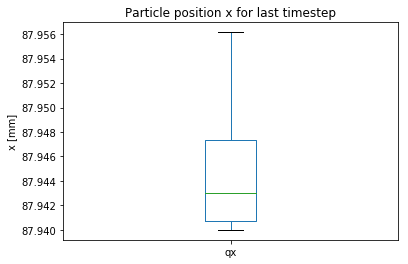

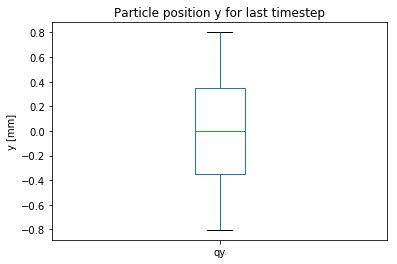

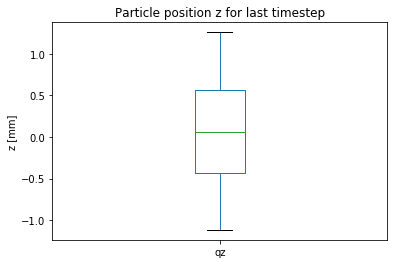

In [4]:
df_cpt = pd.read_csv(file_cpt, skiprows=8, header=None)

# find column headers
c = []
with open(file_cpt, 'r') as myfile:
    for line in myfile:
        if 'Index' in line:
            l = line.rstrip().split(',')
            c.append(l)

myfile.close()
cols = c[0]
# print(c)
# get the time stepping
# extract t=... from the cols
my_cols = []
for ii in range(0,len(cols)):
    col = cols[ii]

    t0 = re.findall(r'(t=.*)', col)
    if len(t0) > 0:
        my_cols.append(t0[0])
    else:
        my_cols.append('noTimestamp')

# timeStep = my_cols[4]
time_cols = (pd.Series(item for item in my_cols)).unique()[1:] # drop the timestamp

#set column header of df
cols[0] = 'particleindex'
df_cpt.columns = cols

# check which particles have arrived at the target
# get the latest timestamp
df_last = df_cpt.filter(regex=time_cols[-1], axis=1)

# length: total number of particles
n_total = len(df_last)

# only those particles that have made it to the target: 10 mm in +x direction
# for dist in [1,5,10,80]:
dist_min = 50.0
dist_max = 90.0  # needs to be adjusted for the 10.run
df_arrived = df_last[ (df_last.iloc[:,0] > dist_min) &(df_last.iloc[:,0] < dist_max) ]
cols = df_arrived.columns

assert 'qx' in cols[0]
assert 'qy' in cols[1]
assert 'qz' in cols[2]

df_arrived.columns = ['qx', 'qy', 'qz']
n_arrived = len(df_arrived)
# print(df_last)
# print(df_last)
# percent of those that have arrived
perc_arrived = round((n_arrived / n_total)*100.0,2)

print('{}% of the initial {} particles have arrived at the target (x > {} mm and x < {} mm).'.format(perc_arrived, n_total, dist_min, dist_max))
if perc_arrived < 10:
    print('{}% smaller than 10 %, avoid this file).'.format(perc_arrived))


df_arrived.plot(kind='box', y='qx')
plt.title('Particle position x for last timestep')
plt.ylabel('x [mm]')
df_arrived.plot(kind='box', y='qy')
plt.title('Particle position y for last timestep')
plt.ylabel('y [mm]')
df_arrived.plot(kind='box', y='qz')
plt.title('Particle position z for last timestep')
plt.ylabel('z [mm]')
plt.show()

# index of the particle that have arrived at the target
idx_arrived = df_arrived.index.tolist()


# select only the last timestep
df_cpt = df_cpt.filter(regex=time_cols[-1], axis=1)

In [5]:
print(f'There are {len(df_cpt)} particles in the dataframe for the export of particle postition available.')

cols = df_cpt.columns

assert 'qx' in cols[0]
assert 'qy' in cols[1]
assert 'qz' in cols[2]

df_cpt.columns = ['qx0', 'qy0', 'qz0']
df_cpt = np.round(df_cpt, 4)

print(df_cpt.head())
print(df_cpt.tail())

There are 5000 particles in the dataframe for the export of particle postition available.
       qx0     qy0     qz0
0  87.9523 -0.7019  0.2822
1  87.9525 -0.7070  0.2446
2  87.9527 -0.7117  0.2071
3  87.9528 -0.7165  0.1691
4  87.9521 -0.6964  0.2628
          qx0     qy0     qz0
4995  87.9542  0.7545  0.0945
4996  87.9537  0.7406  0.0958
4997  87.9544  0.7592  0.1105
4998  87.9542  0.7537  0.1293
4999  87.9538  0.7416  0.1326


### 4. Export in txt with the correct format

In [6]:
# conversion to m

df_cpt = df_cpt.multiply(unit)

print(df_cpt.head())
print(df_cpt.tail())

df_cpt.to_csv(file_export, index=False, sep=' ', header=None)

       qx0     qy0     qz0
0  87.9523 -0.7019  0.2822
1  87.9525 -0.7070  0.2446
2  87.9527 -0.7117  0.2071
3  87.9528 -0.7165  0.1691
4  87.9521 -0.6964  0.2628
          qx0     qy0     qz0
4995  87.9542  0.7545  0.0945
4996  87.9537  0.7406  0.0958
4997  87.9544  0.7592  0.1105
4998  87.9542  0.7537  0.1293
4999  87.9538  0.7416  0.1326


### Visualize the data

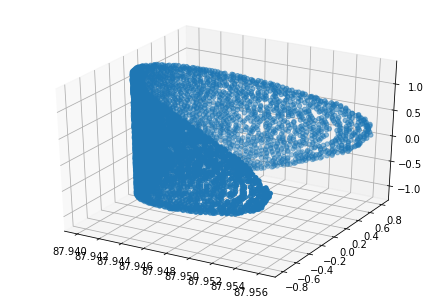

In [7]:
# df_cpt = df_cpt.loc[0:2000, :]
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D


fig = pyplot.figure()
ax = Axes3D(fig)

x = df_cpt['qx0']
y = df_cpt['qy0']
z = df_cpt['qz0']

ax.scatter(x, y, z)
pyplot.show()